In [1]:
%pwd
%cd d:\\Murgi\\code\\memes2024\\meme-research-2024

d:\Murgi\code\memes2024\meme-research-2024


d:\Murgi\code\memes2024\meme-research-2024\phash\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import numpy as np
import pickle
import os
from tqdm.notebook import tqdm

In [3]:
meme_df = pd.read_parquet("D:\Murgi\code\memes2024\meme-research-2024\data\meme_entries.parquet")
meme_df

,id,template_name,path,phash
0,0-days-without-lenny-simpsons,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,0fe9b236e884fc38
1,0-days-without-Lenny-Simpsons_23,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,07e5ba2ee806fe30
2,0-days-without-Lenny-Simpsons_1,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,1fed3226e804fe38
3,0-days-without-Lenny-Simpsons_24,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,07e1b83ee886fa38
4,0-days-without-Lenny-Simpsons_10,0-days-without-lenny-simpsons,D:/Memes2024/0-days-without-Lenny-Simpsons/0-d...,17e5b22ee806fe30
...,...,...,...,...
124196,skeleton-computer-84,skeleton-computer,D:/Memes2024/Skeleton-Computer/skeleton-comput...,e1e68b1929253d3d
124197,nick-young-178,nick-young,D:/Memes2024/Nick-Young/nick-young-178.jpg,4bd5913e14da4e55
124198,success-kid-original-196,success-kid-original,D:/Memes2024/Success-Kid-Original/success-kid-...,1d1d301f32c3f2e3
124199,Wrong-Neighboorhood-Cats_23,wrong-neighboorhood-cats,D:/Memes2024/Wrong-Neighboorhood-Cats/Wrong-Ne...,a950535053abb3bb


In [4]:
phashes = meme_df["phash"].values
phashes

array(['0fe9b236e884fc38', '07e5ba2ee806fe30', '1fed3226e804fe38', ...,
       '1d1d301f32c3f2e3', 'a950535053abb3bb', '4f420398f03f7c7a'],
      dtype=object)

In [5]:
def hex_to_hash(hexstr, hash_size=8):

    l = []
    count = hash_size * (hash_size // 4)
    if len(hexstr) != count:
        emsg = 'Expected hex string size of {}.'
        raise ValueError(emsg.format(count))
    for i in range(count // 2):
        h = hexstr[i*2:i*2+2]
        v = int("0x" + h, 16)
        l.append([v & 2**i > 0 for i in range(8)])
    return np.array(l).flatten()#.astype(int)
    
def precompute_vectors(hashes, phases_path):
    pickle_file = phases_path + '.pickle'
    if os.path.isfile(pickle_file): 
        with open(pickle_file, 'rb') as fo:
            hashes = pickle.load(fo)
        print('[w] fetch precomputed vectors from ', pickle_file, 'new processed', len(hashes))
        return np.array(hashes)
    else:
        # hashes = np.array(list(hashes.values()))
        hashes2 = []
        for hex_hash in tqdm(hashes, total=len(hashes)):
            try:
                hashes2.append(hex_to_hash(hex_hash))
            except Exception as e:
                print(hex_hash)
                print(str(e))
        with open(pickle_file, 'wb') as fo:
            pickle.dump(hashes2, fo)
    return np.array(hashes2)

phash_vectors = precompute_vectors(phashes, 'all_imgflip_phash_vectors')

[w] fetch precomputed vectors from  all_imgflip_phash_vectors.pickle new processed 124201


In [6]:
from sklearn.preprocessing import LabelEncoder

X = phash_vectors
le = LabelEncoder()
le.fit(meme_df['template_name'])
meme_df['template_id'] = le.transform(meme_df['template_name'])
y = meme_df['template_id'].tolist()
X.shape, len(y)


((124201, 64), 124201)

In [7]:
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

rnn = RadiusNeighborsClassifier(radius=10, weights='distance', metric='manhattan', outlier_label=-1, n_jobs=-1)
skf = StratifiedKFold(n_splits=5)

train_index, test_index = next(skf.split(X, y))
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]

rnn.fit(X_train, y_train)

RadiusNeighborsClassifier(metric='manhattan', n_jobs=-1, outlier_label=-1,
                          radius=10, weights='distance')

Load labeled SM images

In [10]:
sm_df = pd.read_parquet(r"D:\Murgi\code\meme-evaluator\v3\holy_grail_all.parquet")
sm_df

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,rnn_prediction,touch_prediction,touch_binary,sparse_binary,phash_binary,cnn_binary,rnn_binary,path,phash
0,2021.11.15_889,templateless,0,templateless,templateless,scared-hamster,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,73e0d886a55e99b1
1,2021.11.19_551,templateless,0,templateless,templateless,templateless,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,f1c93e1e8f70c1e0
2,2021.11.20_438,templateless,0,can-i-offer-you-an-egg-in-these-trying-times,templateless,think-mark-think,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,1de50b0176b0eebc
3,2021.11.20_858,templateless,0,scumbag-brain,templateless,turn-up-the-volume,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,777c098782a9f259
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,coronavirus-7244,templateless,0,templateless,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/coronavirus...,b31f52706cc76670
996,imemeit_added-15546,templateless,0,templateless,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,23d9caa73c1c87e2
997,imemeit_added-16353,templateless,0,templateless,templateless,keep-calm-and-carry-on-purple,templateless,templateless,0.0,0.0,0.0,1.0,0.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,2b83545abc0bd4bd
998,verynicememethanks_added-47232,templateless,0,templateless,templateless,wanted-poster,templateless,templateless,0.0,0.0,0.0,1.0,0.0,D:/Murgi/Facebook2023/Facebook2023/verynicemem...,1595ebb5b6914968


Add phash vectors to the df from file

In [9]:
path_phash = {}
with open(r"D:\Murgi\code\memes2024\meme-research-2024\phashes.txt", "r") as f:
    lines = f.readlines()
    for line in lines:
        path, phash = line.strip().split("\t")
        path_phash[path] = phash

sm_phash_df = pd.DataFrame(path_phash.items(), columns=['path', 'phash'])
sm_df = sm_df.merge(sm_phash_df, on='path')
sm_df

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,rnn_prediction,touch_prediction,touch_binary,sparse_binary,phash_binary,cnn_binary,rnn_binary,path,phash_x,phash_y
0,2021.11.15_889,templateless,0,templateless,templateless,scared-hamster,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,73e0d886a55e99b1,73e0d886a55e99b1
1,2021.11.19_551,templateless,0,templateless,templateless,templateless,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,f1c93e1e8f70c1e0,f1c93e1e8f70c1e0
2,2021.11.20_438,templateless,0,can-i-offer-you-an-egg-in-these-trying-times,templateless,think-mark-think,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,1de50b0176b0eebc,1de50b0176b0eebc
3,2021.11.20_858,templateless,0,scumbag-brain,templateless,turn-up-the-volume,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,777c098782a9f259,777c098782a9f259
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16,6761a8de031bfc16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,coronavirus-7244,templateless,0,templateless,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/coronavirus...,b31f52706cc76670,b31f52706cc76670
996,imemeit_added-15546,templateless,0,templateless,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,23d9caa73c1c87e2,23d9caa73c1c87e2
997,imemeit_added-16353,templateless,0,templateless,templateless,keep-calm-and-carry-on-purple,templateless,templateless,0.0,0.0,0.0,1.0,0.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,2b83545abc0bd4bd,2b83545abc0bd4bd
998,verynicememethanks_added-47232,templateless,0,templateless,templateless,wanted-poster,templateless,templateless,0.0,0.0,0.0,1.0,0.0,D:/Murgi/Facebook2023/Facebook2023/verynicemem...,1595ebb5b6914968,1595ebb5b6914968


Save df with also phash vectors

In [21]:
sm_df.to_parquet(r"D:\Murgi\code\meme-evaluator\v3\holy_grail_all.parquet")

Convert SM phashes to binary vectors

In [11]:
sm_phashes = sm_df["phash"].values

sm_phash_binary = precompute_vectors(sm_phashes, 'sm_phash_vectors')
X_test = sm_phash_binary

  0%|          | 0/1000 [00:00<?, ?it/s]

Inference on the social media images using the best RNN model

In [12]:
y_pred = rnn.predict(X_test)
y_pred

d:\Murgi\code\memes2024\meme-research-2024\phash\lib\site-packages\sklearn\neighbors\_classification.py:768: UserWarning: Outlier label -1 is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(


array([  -1,   -1,   -1,   -1,  404,   -1,  404,   -1,   -1,   -1,   -1,
         -1,   -1,  855,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   21,   -1,   -1,  854,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,  164,   -1,   -1,   -1,   -1,  369,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   24,   -1,   -1,
         -1,   58,   -1,   -1,  412,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,  711,
        968,   -1,   -1,   -1,  404,   -1,   -1,   -1,   -1,   -1,  362,
        402,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,  523,  367,   -1,   60,   -1,  172,   -1,
        412,  628,   -1,   -1,   -1,   -1,   -1,  404,  609,   -1,  994,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,  152,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   

Add predictions to the df

In [13]:
sm_df.drop(columns=['rnn_prediction','rnn_binary'], inplace=True)
sm_df

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,touch_prediction,touch_binary,sparse_binary,phash_binary,cnn_binary,path,phash
0,2021.11.15_889,templateless,0,templateless,templateless,scared-hamster,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,73e0d886a55e99b1
1,2021.11.19_551,templateless,0,templateless,templateless,templateless,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,f1c93e1e8f70c1e0
2,2021.11.20_438,templateless,0,can-i-offer-you-an-egg-in-these-trying-times,templateless,think-mark-think,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,1de50b0176b0eebc
3,2021.11.20_858,templateless,0,scumbag-brain,templateless,turn-up-the-volume,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,777c098782a9f259
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,coronavirus-7244,templateless,0,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/coronavirus...,b31f52706cc76670
996,imemeit_added-15546,templateless,0,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,23d9caa73c1c87e2
997,imemeit_added-16353,templateless,0,templateless,templateless,keep-calm-and-carry-on-purple,templateless,0.0,0.0,0.0,1.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,2b83545abc0bd4bd
998,verynicememethanks_added-47232,templateless,0,templateless,templateless,wanted-poster,templateless,0.0,0.0,0.0,1.0,D:/Murgi/Facebook2023/Facebook2023/verynicemem...,1595ebb5b6914968


In [14]:
y_pred.shape

(1000,)

In [26]:
sm_df['encoded_predictions'] = y_pred
sm_df['rnn_prediction'] = sm_df.loc[:,'encoded_predictions'].apply(lambda x: le.inverse_transform([x])[0] if x != -1 else 'templateless')
sm_df

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,touch_prediction,touch_binary,sparse_binary,phash_binary,cnn_binary,path,phash,rnn_prediction,rnn_binary,encoded_predictions
0,2021.11.15_889,templateless,0,templateless,templateless,scared-hamster,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,73e0d886a55e99b1,templateless,0,-1
1,2021.11.19_551,templateless,0,templateless,templateless,templateless,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,f1c93e1e8f70c1e0,templateless,0,-1
2,2021.11.20_438,templateless,0,can-i-offer-you-an-egg-in-these-trying-times,templateless,think-mark-think,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,1de50b0176b0eebc,templateless,0,-1
3,2021.11.20_858,templateless,0,scumbag-brain,templateless,turn-up-the-volume,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,777c098782a9f259,templateless,0,-1
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16,gus-fring-we-are-not-the-same,1,404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,coronavirus-7244,templateless,0,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/coronavirus...,b31f52706cc76670,templateless,0,-1
996,imemeit_added-15546,templateless,0,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,23d9caa73c1c87e2,templateless,0,-1
997,imemeit_added-16353,templateless,0,templateless,templateless,keep-calm-and-carry-on-purple,templateless,0.0,0.0,0.0,1.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,2b83545abc0bd4bd,templateless,0,-1
998,verynicememethanks_added-47232,templateless,0,templateless,templateless,wanted-poster,templateless,0.0,0.0,0.0,1.0,D:/Murgi/Facebook2023/Facebook2023/verynicemem...,1595ebb5b6914968,templateless,0,-1


In [28]:
# sm_df['ground_truth_binary'] = sm_df['ground_truth'].apply(lambda x: 1 if x != 'templateless' else 0)
sm_df['rnn_binary'] = sm_df['rnn_prediction'].apply(lambda x: 1 if x != 'templateless' else 0)
sm_df.drop(columns=['encoded_predictions'], inplace=True)
sm_df

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,touch_prediction,touch_binary,sparse_binary,phash_binary,cnn_binary,path,phash,rnn_prediction,rnn_binary
0,2021.11.15_889,templateless,0,templateless,templateless,scared-hamster,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,73e0d886a55e99b1,templateless,0
1,2021.11.19_551,templateless,0,templateless,templateless,templateless,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,f1c93e1e8f70c1e0,templateless,0
2,2021.11.20_438,templateless,0,can-i-offer-you-an-egg-in-these-trying-times,templateless,think-mark-think,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,1de50b0176b0eebc,templateless,0
3,2021.11.20_858,templateless,0,scumbag-brain,templateless,turn-up-the-volume,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,777c098782a9f259,templateless,0
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16,gus-fring-we-are-not-the-same,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,coronavirus-7244,templateless,0,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/coronavirus...,b31f52706cc76670,templateless,0
996,imemeit_added-15546,templateless,0,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,23d9caa73c1c87e2,templateless,0
997,imemeit_added-16353,templateless,0,templateless,templateless,keep-calm-and-carry-on-purple,templateless,0.0,0.0,0.0,1.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,2b83545abc0bd4bd,templateless,0
998,verynicememethanks_added-47232,templateless,0,templateless,templateless,wanted-poster,templateless,0.0,0.0,0.0,1.0,D:/Murgi/Facebook2023/Facebook2023/verynicemem...,1595ebb5b6914968,templateless,0


              precision    recall  f1-score   support

           0       0.87      0.98      0.92       753
           1       0.89      0.53      0.67       247

    accuracy                           0.87      1000
   macro avg       0.88      0.76      0.79      1000
weighted avg       0.87      0.87      0.86      1000



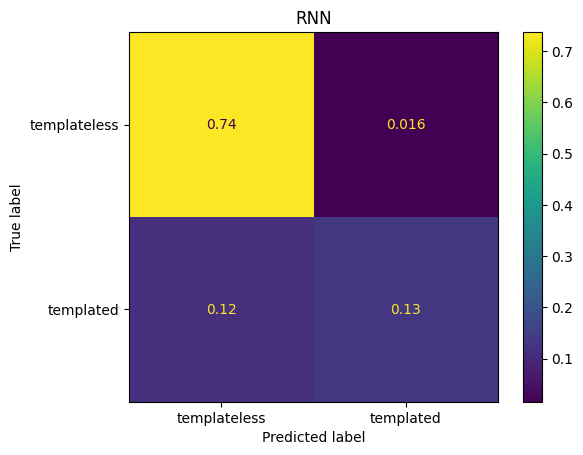

In [17]:
from sklearn.metrics import classification_report
# import confusion_matrix_pretty_print
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json 

print(classification_report(sm_df['binary_true_encoded'], sm_df['rnn_binary']))
report = classification_report(sm_df['binary_true_encoded'], sm_df['rnn_binary'], output_dict=True)
with open(f"D:\Murgi\code\memes2024\meme-research-2024/reports/binary-reports/1000-binary-report-rnn.json", "w") as f:
    json.dump(report, f, indent=4)

cm = confusion_matrix(sm_df['binary_true_encoded'], sm_df['rnn_binary'], normalize="all")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['templateless', 'templated'])
disp.plot()
plt.title("RNN")
plt.show()

# Check the accuracy on memes that WE thought are templated

In [29]:
gt_df_true_templated = sm_df[sm_df['binary_true_encoded'] == 1]
gt_df_true_templated

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,touch_prediction,touch_binary,sparse_binary,phash_binary,cnn_binary,path,phash,rnn_prediction,rnn_binary
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16,gus-fring-we-are-not-the-same,1
6,2021.11.21_977,gus-fring-we-are-not-the-same,1,templateless,templateless,gus-fring-we-are-not-the-same,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,c9db2674a1701797,gus-fring-we-are-not-the-same,1
13,2021.11.29_328,skeletor-disturbing-facts,1,templateless,skeletor-disturbing-facts,skeletor-disturbing-facts,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,4322a7fc7c67128b,skeletor-disturbing-facts,1
18,2021.12.06_275,you-guys-always-act-like-youre-better-than-me,1,nobody-absolutely-no-one,templateless,templateless,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,778824cf7e358952,templateless,0
23,2021.12.08_89,i-think-i-forgot-something,1,templateless,templateless,i-think-i-forgot-something,None,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,0f4dd212e9ec469d,templateless,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,444169716245436_added-13861,case1,1,maybe-i-am-a-monster,templateless,mom-can-we-have,im-about-to-end-this-mans-whole-career,1.0,1.0,0.0,1.0,D:/Murgi/Facebook2023/Facebook2023/44416971624...,35435bb024edd333,templateless,0
986,DankMagicMemes_added-10534,case1-spray kid,1,templateless,templateless,crying-wojak-vs-chad,templateless,0.0,0.0,0.0,1.0,D:/Murgi/Facebook2023/Facebook2023/DankMagicMe...,53cb2d45fa8256cc,templateless,0
989,DankMagicMemes_added-13013,case1,1,black-girl-wat,templateless,inception,templateless,0.0,1.0,0.0,1.0,D:/Murgi/Facebook2023/Facebook2023/DankMagicMe...,df11383d03df0a87,templateless,0
990,DankMagicMemes_added-13308,case1,1,matrix-morpheus-offer,templateless,oliver-twist-please-sir,pippin-second-breakfast,1.0,1.0,0.0,1.0,D:/Murgi/Facebook2023/Facebook2023/DankMagicMe...,a3348bcaade1564b,liam-neeson-taken,1


In [30]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, cohen_kappa_score

def calc_acc_for_templated_memes(df,model_name:str):
    temp = df
    y_true = temp['template_true'].values
    y_pred = temp[f"{model_name}_prediction"].values
    acc = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)
    return {'accuracy': acc, 'mcc': mcc, 'f1': f1, 'kappa': kappa}

print("Accuracy for templated memes without templateless")
print(calc_acc_for_templated_memes(gt_df_true_templated,"rnn"))

print("Accuracy for all memes including templateless")
print(calc_acc_for_templated_memes(sm_df,"rnn"))

Accuracy for templated memes without templateless
{'accuracy': 0.5141700404858299, 'mcc': 0.5821923531111078, 'f1': 0.5566671202894112, 'kappa': 0.5117370892018778}
Accuracy for all memes including templateless
{'accuracy': 0.864, 'mcc': 0.6459556592562741, 'f1': 0.8281369656273727, 'kappa': 0.620254931799461}


# Check the accuracy on memes that the MODELS thought are templated

In [31]:
def calc_accuracy_on_model_templated(temp, model_name):
    temp = temp[temp[f"{model_name}_prediction"] != 'templateless']
    y_true = temp['template_true'].values
    y_pred = temp[f"{model_name}_prediction"].values
    acc = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)
    return {'accuracy': acc, 'mcc': mcc, 'f1': f1, 'kappa': kappa}


print('Accuracy on only templated memes (defined by models):')
print(calc_accuracy_on_model_templated(sm_df,"rnn"))

Accuracy on only templated memes (defined by models):
{'accuracy': 0.8581081081081081, 'mcc': 0.862211317753917, 'f1': 0.8597972972972973, 'kappa': 0.8564633076248095}


In [32]:

all_memes_true_templated = calc_acc_for_templated_memes(sm_df,"rnn")
only_templated_true_templated = calc_acc_for_templated_memes(gt_df_true_templated,"rnn")
only_templated_model_templates = calc_accuracy_on_model_templated(sm_df,"rnn")
multiclass_accs = {
    "all_memes_true_templated": all_memes_true_templated,
    "only_templated_true_templated": only_templated_true_templated,
    "only_templated_model_templates": only_templated_model_templates
}
with open(f"D:\Murgi\code\memes2024\meme-research-2024/reports\multiclass-reports/1000-multiclass-report-rnn.json", "w") as f:
    json.dump(multiclass_accs, f, indent=4)

In [34]:
sm_df.drop(columns=['rnn_binary','touch_prediction','touch_binary','sparse_binary','phash_binary','cnn_binary'], inplace=True)
sm_df

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,path,phash,rnn_prediction
0,2021.11.15_889,templateless,0,templateless,templateless,scared-hamster,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,73e0d886a55e99b1,templateless
1,2021.11.19_551,templateless,0,templateless,templateless,templateless,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,f1c93e1e8f70c1e0,templateless
2,2021.11.20_438,templateless,0,can-i-offer-you-an-egg-in-these-trying-times,templateless,think-mark-think,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,1de50b0176b0eebc,templateless
3,2021.11.20_858,templateless,0,scumbag-brain,templateless,turn-up-the-volume,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,777c098782a9f259,templateless
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16,gus-fring-we-are-not-the-same
...,...,...,...,...,...,...,...,...,...
995,coronavirus-7244,templateless,0,templateless,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/coronavirus...,b31f52706cc76670,templateless
996,imemeit_added-15546,templateless,0,templateless,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,23d9caa73c1c87e2,templateless
997,imemeit_added-16353,templateless,0,templateless,templateless,keep-calm-and-carry-on-purple,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,2b83545abc0bd4bd,templateless
998,verynicememethanks_added-47232,templateless,0,templateless,templateless,wanted-poster,D:/Murgi/Facebook2023/Facebook2023/verynicemem...,1595ebb5b6914968,templateless


In [35]:
sm_df.to_parquet(r"D:\Murgi\code\meme-evaluator\holy_grail_all.parquet")
sm_df

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,path,phash,rnn_prediction
0,2021.11.15_889,templateless,0,templateless,templateless,scared-hamster,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,73e0d886a55e99b1,templateless
1,2021.11.19_551,templateless,0,templateless,templateless,templateless,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,f1c93e1e8f70c1e0,templateless
2,2021.11.20_438,templateless,0,can-i-offer-you-an-egg-in-these-trying-times,templateless,think-mark-think,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,1de50b0176b0eebc,templateless
3,2021.11.20_858,templateless,0,scumbag-brain,templateless,turn-up-the-volume,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,777c098782a9f259,templateless
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16,gus-fring-we-are-not-the-same
...,...,...,...,...,...,...,...,...,...
995,coronavirus-7244,templateless,0,templateless,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/coronavirus...,b31f52706cc76670,templateless
996,imemeit_added-15546,templateless,0,templateless,templateless,templateless,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,23d9caa73c1c87e2,templateless
997,imemeit_added-16353,templateless,0,templateless,templateless,keep-calm-and-carry-on-purple,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,2b83545abc0bd4bd,templateless
998,verynicememethanks_added-47232,templateless,0,templateless,templateless,wanted-poster,D:/Murgi/Facebook2023/Facebook2023/verynicemem...,1595ebb5b6914968,templateless
